# Twin Delayed Deep Deterministic Policy Gradients (TD3)
---
In this notebook, we train TD3 with OpenAI Gym's BipedalWalker-v2 environment.

### 1. Import the Necessary Packages

In [1]:
import gym
import copy
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Instantiate the Environment and Agent

In [2]:
env = gym.make('BipedalWalker-v2')
env.seed(0)

[0]

In [3]:
# size of each action
action_size = env.action_space
print('Size of each action:', action_size.shape[0])

# upper bond of each action
upper_bond = env.action_space.high
print('Upper bond of each action:', upper_bond[0])

# lower bond of each action
lower_bond = env.action_space.low
print('Lower bond of each action:', lower_bond[0])

# examine the state space 
states = env.observation_space
state_size = states.shape[0]
print('Each observes a state with length: {}'.format(state_size))

Size of each action: 4
Upper bond of each action: 1.0
Lower bond of each action: -1.0
Each observes a state with length: 24


### 3. Setting up hyper parameters and agent

In [4]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 100        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
UPDATE_EVERY_STEP = 2        # how often to update the target and actor networks

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [6]:
class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, max_action, fc1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            max_action (float): the maximum valid value for action
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.max_action = max_action

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.max_action * torch.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, fc1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size + action_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        state_action = torch.cat([state, action], dim=1)
        xs = F.relu(self.fc1(state_action))
        x = F.relu(self.fc2(xs))
        x = self.fc3(x)

        return x

In [7]:
class TD3Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, max_action, min_action, random_seed, noise=0.2, noise_std=0.1, noise_clip=0.5):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            max_action (ndarray): the maximum valid value for each action vector
            min_action (ndarray): the minimum valid value for each action vector
            random_seed (int): random seed
            noise (float): the range to generate random noise while learning
            noise_std (float): the range to generate random noise while performing action
            noise_clip (float): to clip random noise into this range
        """
        self.state_size = state_size
        self.action_size = action_size
        self.max_action = max_action
        self.min_action = min_action
        self.noise = noise
        self.noise_std = noise_std
        self.noise_clip = noise_clip
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, float(max_action[0])).to(device)
        self.actor_target = Actor(state_size, action_size, float(max_action[0])).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local1 = Critic(state_size, action_size).to(device)
        self.critic_target1 = Critic(state_size, action_size).to(device)
        self.critic_target1.load_state_dict(self.critic_local1.state_dict())
        self.critic_optimizer1 = optim.Adam(self.critic_local1.parameters(), lr=LR_CRITIC)
        
        self.critic_local2 = Critic(state_size, action_size).to(device)
        self.critic_target2 = Critic(state_size, action_size).to(device)
        self.critic_target2.load_state_dict(self.critic_local2.state_dict())
        self.critic_optimizer2 = optim.Adam(self.critic_local2.parameters(), lr=LR_CRITIC)
        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
        
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory"""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

            
    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        if add_noise:
            # Generate a random noise
            noise = np.random.normal(0, self.noise_std, size=self.action_size)
            # Add noise to the action for exploration
            action = (action + noise).clip(self.min_action[0], self.max_action[0])
        self.actor_local.train()
        return action

    def learn(self, n_iteraion, gamma=GAMMA):
        """Update policy and value parameters using given batch of experience tuples.
        
        Params
        ======
            n_iteraion (int): the number of iterations to train network
            gamma (float): discount factor
        """
        
        if len(self.memory) > BATCH_SIZE:
            for i in range(n_iteraion):
                state, action, reward, next_state, done = self.memory.sample()

                action_ = action.cpu().numpy()

                # ---------------------------- update critic ---------------------------- #
                # Get predicted next-state actions and Q values from target models
                actions_next = self.actor_target(next_state)

                # Generate a random noise
                noise = torch.FloatTensor(action_).data.normal_(0, self.noise).to(device)
                noise = noise.clamp(-self.noise_clip, self.noise_clip)
                actions_next = (actions_next + noise).clamp(self.min_action[0].astype(float), self.max_action[0].astype(float))

                Q1_targets_next = self.critic_target1(next_state, actions_next)
                Q2_targets_next = self.critic_target2(next_state, actions_next)

                Q_targets_next = torch.min(Q1_targets_next, Q2_targets_next)
                # Compute Q targets for current states (y_i)
                Q_targets = reward + (gamma * Q_targets_next * (1 - done)).detach()
                # Compute critic loss
                Q1_expected = self.critic_local1(state, action)
                Q2_expected = self.critic_local2(state, action)
                critic_loss1 = F.mse_loss(Q1_expected, Q_targets)
                critic_loss2 = F.mse_loss(Q2_expected, Q_targets)
                # Minimize the loss
                self.critic_optimizer1.zero_grad()
                critic_loss1.backward()
                self.critic_optimizer1.step()

                self.critic_optimizer2.zero_grad()
                critic_loss2.backward()
                self.critic_optimizer2.step()

                if i % UPDATE_EVERY_STEP == 0:
                    # ---------------------------- update actor ---------------------------- #
                    # Compute actor loss
                    actions_pred = self.actor_local(state)
                    actor_loss = -self.critic_local1(state, actions_pred).mean()
                    # Minimize the loss
                    self.actor_optimizer.zero_grad()
                    actor_loss.backward()
                    self.actor_optimizer.step()

                    # ----------------------- update target networks ----------------------- #
                    self.soft_update(self.critic_local1, self.critic_target1, TAU)
                    self.soft_update(self.critic_local2, self.critic_target2, TAU)
                    self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [8]:
agent = TD3Agent(state_size=env.observation_space.shape[0], \
                 action_size=env.action_space.shape[0], \
                 max_action=env.action_space.high, \
                 min_action=env.action_space.low, random_seed=0)

### 4. Train the Agent with TD3

Run the code cell below to train the agent from scratch.  Alternatively, you can skip to the next code cell to load the pre-trained weights from file.

Episode 100	Average Score: -114.03	Score: -117.89
Episode 200	Average Score: -114.95	Score: -124.40
Episode 300	Average Score: -114.90	Score: -46.904
Episode 400	Average Score: -107.34	Score: -86.183
Episode 500	Average Score: -94.18	Score: -5.82899
Episode 600	Average Score: 85.09	Score: -9.90206
Episode 700	Average Score: 250.38	Score: 279.678
Save at 700	Average Score: 250.38
Save at 704	Average Score: 251.49	Score: 285.27
Save at 705	Average Score: 253.58	Score: 284.95
Save at 706	Average Score: 253.72	Score: 281.28
Save at 707	Average Score: 253.87	Score: 285.86
Save at 708	Average Score: 254.56	Score: 67.11
Save at 709	Average Score: 254.79	Score: 287.49
Save at 710	Average Score: 254.93	Score: 282.78
Save at 711	Average Score: 255.14	Score: 287.73
Save at 712	Average Score: 255.39	Score: 290.87
Save at 713	Average Score: 255.62	Score: 283.18
Save at 714	Average Score: 255.86	Score: 286.41
Save at 715	Average Score: 256.11	Score: 285.17
Save at 716	Average Score: 256.19	Score: 28

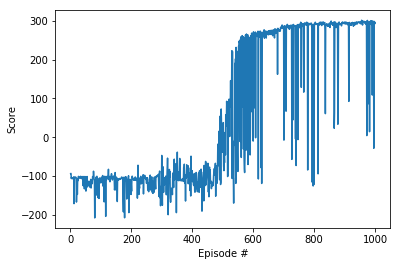

In [10]:
def td3(n_episodes=1000, max_t=2000):
    scores_deque = deque(maxlen=100)
    scores = []
    highest_score = float('-inf')
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done or t==(max_t-1):
                agent.learn(t)
                break
        scores_deque.append(score)
        scores.append(score)
        mean_score = np.mean(scores_deque)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, mean_score, score), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, mean_score)) 
        if mean_score >= 250 and mean_score > highest_score:
            torch.save(agent.actor_local.state_dict(), 'pretrained/bipedal/actor.pth')
            torch.save(agent.critic_local1.state_dict(), 'pretrained/bipedal/critic1.pth')
            torch.save(agent.critic_local2.state_dict(), 'pretrained/bipedal/critic2.pth')
            print('\rSave at {}\tAverage Score: {:.2f}'.format(i_episode, mean_score))
        if mean_score >= 300 and solved == False:
            solved = True
            print('\rSolved at Episode {} !\tAverage Score: {:.2f}'.format(i_episode, mean_score))
        highest_score = max(highest_score, mean_score)
    return scores

scores = td3()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Performance

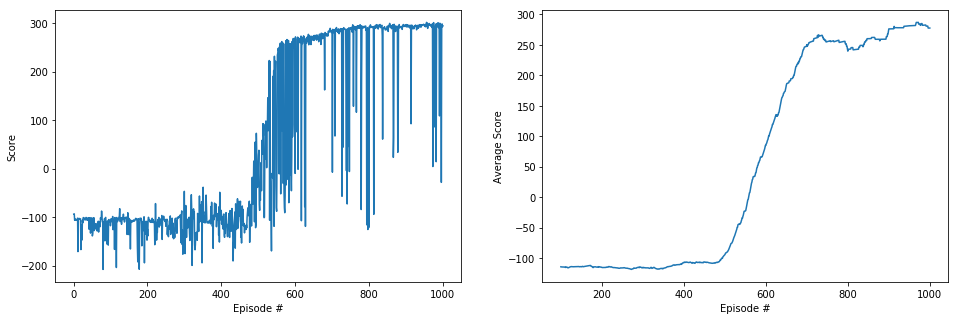

In [37]:
import pandas as pd

fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(121)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')

ay = fig.add_subplot(122)
plt.plot(np.arange(1, len(scores)+1), pd.Series(scores).rolling(100).mean())
plt.ylabel('Average Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch your Agent play!

In the next code cell, you will load the trained weights from file to watch a smart(?) agent!

In [10]:
agent.actor_local.load_state_dict(torch.load('pretrained/bipedal/actor.pth'))
agent.critic_local1.load_state_dict(torch.load('pretrained/bipedal/critic1.pth'))
agent.critic_local2.load_state_dict(torch.load('pretrained/bipedal/critic2.pth'))

state = env.reset()  
while True:
    action = agent.act(state)
    env.render()
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break
        
env.close()